# 05 Transfer Learning in TensorFlow Part 2: Fine-tuning

## Use feature extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

### Preparation for the model creation

In [1]:
# Check for the GPU
!nvidia-smi

Tue Oct 10 17:35:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get the helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-10 17:35:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-10-10 17:35:59 (13.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, walk_through_dir, plot_loss_curves

In [4]:
# Get the training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-10-10 17:36:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 74.125.203.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.9MB/s    in 6.2s    

2023-10-10 17:36:11 (25.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Investigate the data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Create train and test sets
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
# State global variables
IMG_SIZE = (224, 224)
BATCH_SIZE= 32

In [8]:
# Batch the data
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
# Sanity check
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Sanity check 2
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Model creation (base version with frozen EfficientNetB0 weights)

In [11]:
# Prepare needed callback
ckpt_path = "checkpoints/model_ckpt.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path,
                                                      monitor='val_loss',
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      verbose=1)

In [12]:
# Create the base_model with EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model
base_model.trainable = False

# Create the input layer
input_layer = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# Passing the inputs
x = base_model(input_layer)

# Averaging the weights from the base_model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_2d')(x)

# Output layer with activation
output_layer = tf.keras.layers.Dense(10,
                                     activation='softmax',
                                     name='output_layer')(x)

# Combine the inputs and outputs
model_0 = tf.keras.Model(input_layer, output_layer)

# Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
initial_epochs = 10

history_0 = model_0.fit(train_data,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.1*len(test_data)),
                        callbacks=model_checkpoint)

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/10
23/24 [===========================>..] - ETA: 0s - loss: 1.8857 - accuracy: 0.3954
Epoch 1: val_loss improved from inf to 1.29198, saving model to checkpoints/model_ckpt.ckpt
24/24 [==============================] - 23s 262ms/step - loss: 1.8771 - accuracy: 0.4013 - val_loss: 1.2920 - val_accuracy: 0.7545
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.0964 - accuracy: 0.7663
Epoch 2: val_loss improved from 1.29198 to 0.87451, saving model to checkpoints/model_ckpt.ckpt
24/24 [==============================] - 3s 121ms/step - loss: 1.0970 - accuracy: 0.7680 - val_loss: 0.8745 - val_accuracy: 0.8304
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.7876 - accuracy: 0.8410
Epoch 3: val_loss improved from 0.87451 to 0.69706, saving model to checkpoints/model_ckpt.ckpt
24/24 [==============================] - 4s 133ms/step - loss: 0.7840 - accuracy: 0.8427 - val_loss: 0.697

In [13]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4400 - accuracy: 0.8804


[0.4399999976158142, 0.8804000020027161]

As seen, the baseline `model_0` was able to achieve 87.4% of accuracy while being trained on 10% of 10 classes of different food. Now let's continue and try finetuning it to this dataset.

## Fine-tune the last 20 layers of the base model you trained in previos exercise for another epochs. How did it go?

### Layer preparation

In [14]:
# Investigate model layers
print(model_0.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2d   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________
None


In [15]:
model_0.layers

In [16]:
# Investigate further for trainable layers
print(model_0.layers[1].trainable_variables)

[]


There are none since we did freeze them - all good for now.

In [17]:
# To prepare for fine-tuning, unfreezing the last layers is a must. Let's do so
base_model.trainable = True

In [18]:
# Freeze all of the layers except last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

In [19]:
# Check which layers are trainable
for layer_no, layer in enumerate(base_model.layers):
  print(layer_no, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

### Fine tune the model

In [20]:
# Recompile the model with lower learning rate (good practice for fine-tuning)
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [21]:
# Sanity check for unfrozen layers
len(model_0.trainable_variables)

21

In [22]:
# As per exercise - fine-tuning is required for additional 10 epochs
fine_tune_epochs = initial_epochs + 10

# Fine-tuning the model
history_0_fine_1 = model_0.fit(train_data,
                               epochs=fine_tune_epochs,
                               steps_per_epoch=len(train_data),
                               validation_data=test_data,
                               validation_steps=int(0.1*len(test_data)),
                               initial_epoch=history_0.epoch[-1],
                               callbacks=model_checkpoint)

Epoch 10/20
23/24 [===========================>..] - ETA: 0s - loss: 0.7442 - accuracy: 0.8465
Epoch 10: val_loss improved from 0.44340 to 0.32264, saving model to checkpoints/model_ckpt.ckpt
24/24 [==============================] - 17s 192ms/step - loss: 0.7452 - accuracy: 0.8453 - val_loss: 0.3226 - val_accuracy: 0.9196
Epoch 11/20
23/24 [===========================>..] - ETA: 0s - loss: 0.4806 - accuracy: 0.9212
Epoch 11: val_loss did not improve from 0.32264
24/24 [==============================] - 2s 85ms/step - loss: 0.4841 - accuracy: 0.9187 - val_loss: 0.3297 - val_accuracy: 0.9107
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.9547
Epoch 12: val_loss did not improve from 0.32264
24/24 [==============================] - 3s 131ms/step - loss: 0.3616 - accuracy: 0.9547 - val_loss: 0.3323 - val_accuracy: 0.9062
Epoch 13/20
23/24 [===========================>..] - ETA: 0s - loss: 0.2658 - accuracy: 0.9633
Epoch 13: val_loss did not improve

Looks alike model is quite heavily overfitted, but the plots should make it a much clearer picture.

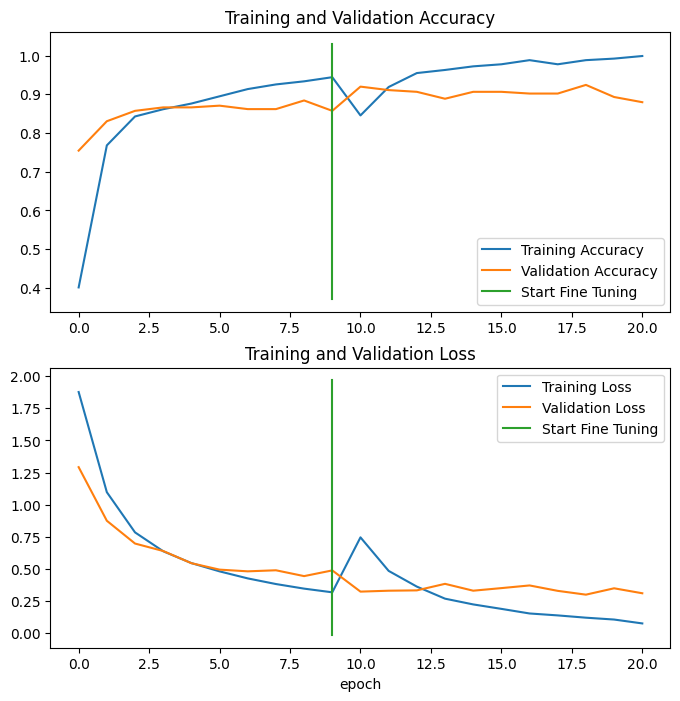

In [23]:
from helper_functions import compare_historys
compare_historys(history_0,
                 history_0_fine_1,
                 initial_epochs=10)

I suppose it easy to spot that validation loss and training loss are starting to move from each other the longer the fine-tuning is performed. The sweet spot is probably somewhere between 12 and 13 epochs (so 2-3 epochs of fine-tuning).

## Fine-tune the last 30 layers of the base model you've trained in previous exercise for another 10 epochs. How did it go this time?

### Prepare the architecture

In [24]:
# Check the summary again
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2d   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 1363770 (5.20 MB)
Non-trainable params: 2698611 (10.29 MB)
_________________________________________________________________


In [25]:
# Check further
len(model_0.layers[1].trainable_variables)

19

In [26]:
# Unfreeze all of the layers is base model
base_model.trainable = True

In [27]:
# Freeze anything but last 30 layers
for layer in base_model.layers[:-30]:
  layer.trainable = False

In [28]:
# Check for if the freeze is performed properly
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [29]:
# Sanity check
len(base_model.trainable_variables)

28

In [30]:
# Recompile the model yet again with even lower learning rate
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['accuracy'])

In [31]:
len(model_0.trainable_variables)

30

### Prepare the model and tune it (again)

In [32]:
fine_tune_epochs_2 = fine_tune_epochs + 10

# Fine tune the model
history_0_fine_2 = model_0.fit(train_data,
                               epochs=fine_tune_epochs_2,
                               steps_per_epoch=len(train_data),
                               initial_epoch=history_0_fine_1.epoch[-1],
                               validation_data=test_data,
                               validation_steps=int(0.1*len(test_data)),
                               callbacks=model_checkpoint)

Epoch 20/30
23/24 [===========================>..] - ETA: 0s - loss: 0.1055 - accuracy: 0.9891
Epoch 20: val_loss did not improve from 0.29897
24/24 [==============================] - 16s 171ms/step - loss: 0.1082 - accuracy: 0.9880 - val_loss: 0.3092 - val_accuracy: 0.8973
Epoch 21/30
23/24 [===========================>..] - ETA: 0s - loss: 0.1041 - accuracy: 0.9905
Epoch 21: val_loss improved from 0.29897 to 0.28604, saving model to checkpoints/model_ckpt.ckpt
24/24 [==============================] - 3s 108ms/step - loss: 0.1047 - accuracy: 0.9907 - val_loss: 0.2860 - val_accuracy: 0.9330
Epoch 22/30
23/24 [===========================>..] - ETA: 0s - loss: 0.0929 - accuracy: 0.9946
Epoch 22: val_loss did not improve from 0.28604
24/24 [==============================] - 3s 103ms/step - loss: 0.0927 - accuracy: 0.9947 - val_loss: 0.3060 - val_accuracy: 0.9018
Epoch 23/30
23/24 [===========================>..] - ETA: 0s - loss: 0.0974 - accuracy: 0.9946
Epoch 23: val_loss did not improv

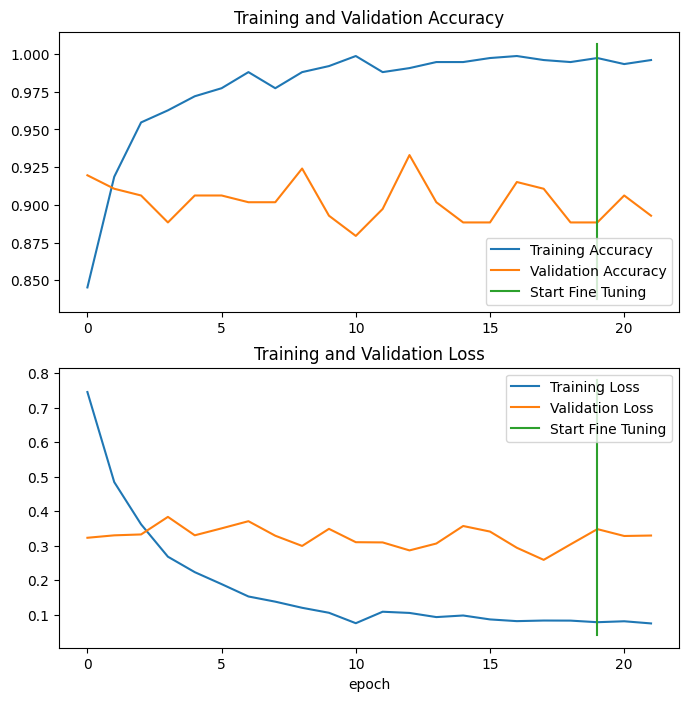

In [33]:
# Compare the results
compare_historys(history_0_fine_1,
                 history_0_fine_2,
                 initial_epochs=fine_tune_epochs)

In [34]:
# Load the best weights
model_0.load_weights(ckpt_path)

In [35]:
# Evaluate the model on it's best performing weights
model_0.evaluate(test_data)

79/79 [==============================] - 5s 57ms/step - loss: 0.3647 - accuracy: 0.8864


[0.36467957496643066, 0.8863999843597412]

Although the performance in pure accuracy did not increase lot, the validation loss is the metric we've managed to reduce (from 0.443 to 0.363).

What was also very visible is model overfitting on the data a bit. There may be various reasons of this:
- too little data (can download the bigger dataset)
- too repetitive pictures (data augmentation could help)
- wrong number of layers being unfrozen/fine-tuned

All this could possibly lead to even better results.

## Write a function to visualize an image from any dataset (either train or test) and any class. Visualize it, make a prediction and compare it with the truth label.

In [36]:
def create_prediction(dataset=test_data):
  import random
  import matplotlib.pyplot as plt

  iterator = iter(dataset)

  try:
    batch_sample = next(iterator)
  except Exception as e:
    print(e)

  choice = random.randint(0,32)

  img = batch_sample[0][choice]
  img_exp = tf.expand_dims(img, axis=0)

  label = batch_sample[1][choice]

  pred = model_0.predict(img_exp, verbose=0)
  pred_img_label = pred.round().argmax(1)[0]

  plt.imshow(img/255.)
  plt.axis('off')
  plt.title(f"Truth: {dataset.class_names[tf.argmax(label)]}\n\
    Prediction: {dataset.class_names[pred_img_label]}\n\
    Probability: {pred.max(1)[0]:.2f}")

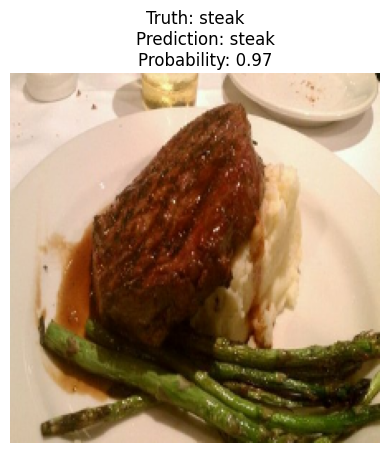

In [37]:
create_prediction(train_data)

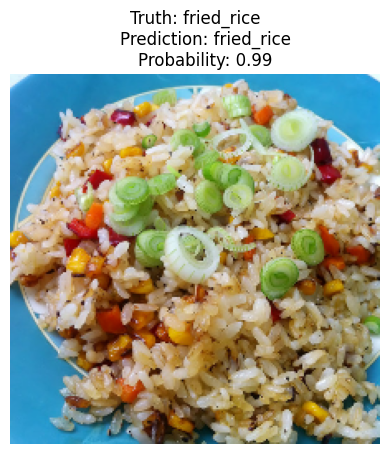

In [38]:
create_prediction(test_data)